In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models 
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)
unloader = transforms.ToPILImage()

def imshow(tensor, title = None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


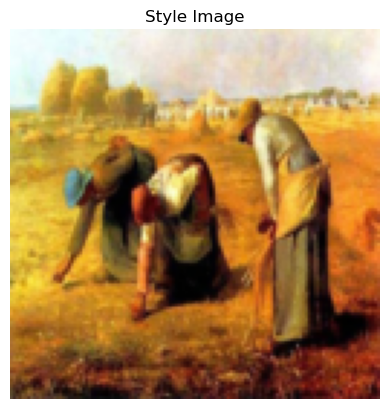

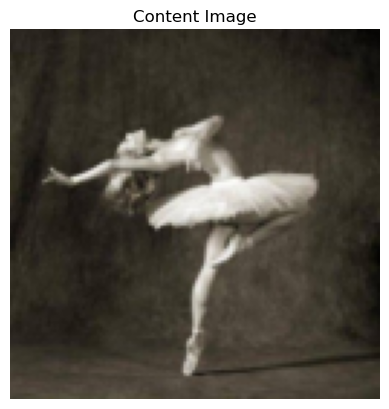

In [4]:
style_img = image_loader("./StyleTransfer/des_glaneuses.jpg")
content_img = image_loader("./StyleTransfer/dancing.jpg")
print(style_img.shape, content_img.shape)
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')


In [37]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [38]:
def gram_matrix(input):
    #a: 批量(1)
    #b: feature map 數量
    #(c, d): featurn map 維度大小(N = c*d)
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [39]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [40]:
cnn = models.vgg19(pretrained = True).features.to(device).eval()

C:\Users\ian\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ian\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [42]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [59]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers = content_layers_default, style_layers = style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace = False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')
        
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
       
    model = model[:(i + 1)]
    return model, style_losses, content_losses

In [67]:
def get_input_optimizer(input_img):
    # 設定 input image 要優化 
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std, content_img, style_img, input_img, num_steps = 300, style_weight = 1000000, content_weight = 1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    optimizer = get_input_optimizer(input_img)
    print('優化 ..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)
                
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
            return style_score + content_score
                      
        optimizer.step(closure)
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [68]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..


C:\Users\ian\AppData\Local\Temp\ipykernel_8748\3189525153.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\ian\AppData\Local\Temp\ipykernel_8748\3189525153.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


優化 ..
run [50]:
Style Loss : 658.957520 Content Loss: 39.751545

run [100]:
Style Loss : 123.793709 Content Loss: 38.818096

run [150]:
Style Loss : 64.859680 Content Loss: 37.676678

run [200]:
Style Loss : 43.383400 Content Loss: 36.346153

run [250]:
Style Loss : 31.066763 Content Loss: 34.482773

run [300]:
Style Loss : 23.427147 Content Loss: 32.725044



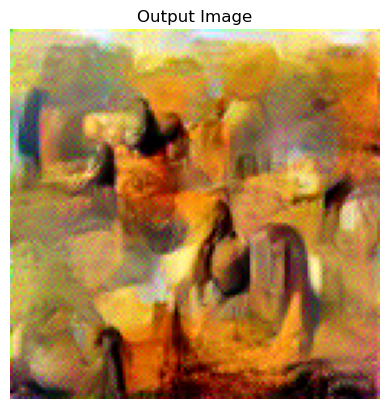

In [69]:
plt.ion()

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


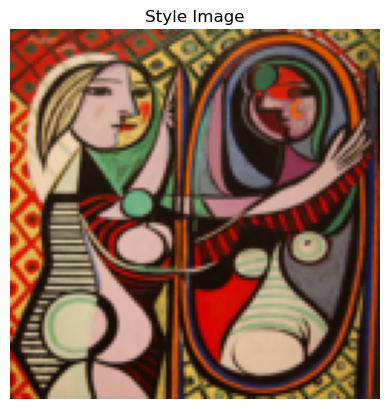

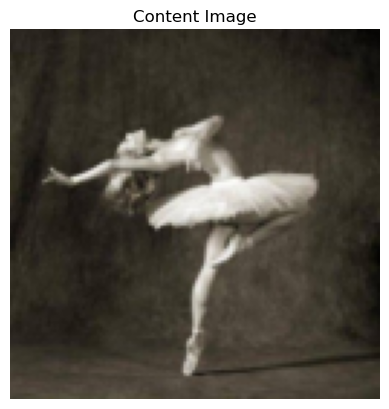

In [70]:
style_img = image_loader("./StyleTransfer/mirror.jpg")
content_img = image_loader("./StyleTransfer/dancing.jpg")
print(style_img.shape, content_img.shape)
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

Building the style transfer model..
優化 ..


C:\Users\ian\AppData\Local\Temp\ipykernel_8748\3189525153.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\ian\AppData\Local\Temp\ipykernel_8748\3189525153.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 2171.620850 Content Loss: 82.545792

run [100]:
Style Loss : 524.914734 Content Loss: 83.665909

run [150]:
Style Loss : 246.358566 Content Loss: 83.602226

run [200]:
Style Loss : 142.918427 Content Loss: 83.204697

run [250]:
Style Loss : 97.796059 Content Loss: 83.121887

run [300]:
Style Loss : 271.636017 Content Loss: 82.388672



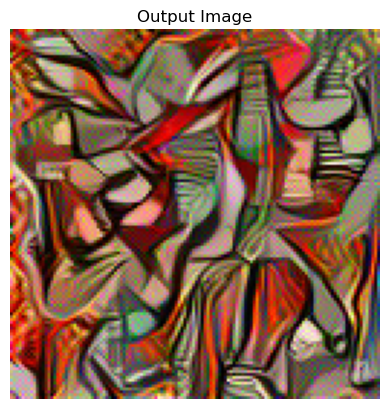

In [73]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.ion()

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()